In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
%load_ext autoreload
%autoreload 2
from disambiguation import Benchmark
import disambiguation.processing as dp
import interpolation
from sklearn.pipeline import Pipeline
from category_encoders.target_encoder import TargetEncoder
from sklearn.linear_model import LinearRegression

In [2]:
filled_1850 = pd.read_csv("../data/dwelling_filled_sum_1850_mn.csv")
census_1880 = pd.read_csv("../data/census_1880_mn_blocks.csv")

/Users/tabithasugumar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Problem: We want to figure out block numbers for 1850 data. This is somewhat similar to figuring out street names in how much information there will be available. Here we'll also explore the issues inherant with combining census and city directory data from 1880 in the benchmarking process since block number is in city directory data and the granualarity we need is in the census data

1. Work out approaches for figuring out block numbers
    - Also applicable to street name problem
2. Understand combining city directory and census information from 1880, as this isn't inherently entirely accurate

In [3]:
filled_1850.head()

,BLOCK_NUM,CD_ADDRESS,CD_X,CD_Y,CENSUS_AGE,CENSUS_CITY,CENSUS_DWELLING_NUM,CENSUS_DWELLING_SEQ,CENSUS_DWELLING_SIZE,CENSUS_GEOG,...,CENSUS_PLACE,CENSUS_RACE,CENSUS_REEL_HOUSEHOLD,CENSUS_SEQ_NUM,CENSUS_SERIALP,CENSUS_SEX,CENSUS_WARD_NUM,selected,spatial_weight,spatial_weight_sum
0,3794.0,37 South,-74.00825,40.703128,49,4610,1.0,1.0,84,NEW YORK WARD 1 EASTERN DIVISION,...,MANHATTAN,120,534,1,2044262,1,1,NaN,NaN,NaN
1,3794.0,37 South,-74.00825,40.703128,36,4610,1.0,1.0,84,NEW YORK WARD 1 EASTERN DIVISION,...,MANHATTAN,120,534,2,2044263,2,1,NaN,NaN,NaN
2,3794.0,37 South,-74.00825,40.703128,12,4610,1.0,1.0,84,NEW YORK WARD 1 EASTERN DIVISION,...,MANHATTAN,120,534,3,2044264,2,1,NaN,NaN,NaN
3,3794.0,37 South,-74.00825,40.703128,40,4610,1.0,1.0,84,NEW YORK WARD 1 EASTERN DIVISION,...,MANHATTAN,120,534,4,2044265,1,1,NaN,NaN,NaN
4,3794.0,37 South,-74.00825,40.703128,28,4610,1.0,1.0,84,NEW YORK WARD 1 EASTERN DIVISION,...,MANHATTAN,120,534,5,2044266,2,1,NaN,NaN,NaN


In [3]:
census_1880.dropna(subset = ["block_num"], inplace = True)
census_1880.reset_index(inplace = True)

In [4]:
#For now let's get rid of data in 1850 without a dweling number, this is for simplicity
#and consistency since we do a lot based on dwelling number in 1850, but it's something to
#keep thinking about
filled_1850.dropna(subset = ["CENSUS_DWELLING_NUM"], inplace = True)
#change column names so consistant accross the datasets
filled_1850.rename(columns = {"CENSUS_WARD_NUM":"WARD_NUM", "CENSUS_SERIALP":"CENSUS_SERIALB", "BLOCK_NUM":"block_num"}, inplace = True)

In [5]:
print("Number of Dwellings in 1880 Census:", census_1880["CENSUS_ADDRESS"].nunique())
print("Number of Dwellings in 1850:", filled_1850.groupby(["WARD_NUM", "CENSUS_DWELLING_NUM"]).ngroups)

Number of Dwellings in 1880 Census: 50572
Number of Dwellings in 1850: 19825


To me, this suggests that we can use the city directory information from 1880 directory instead of combining the two. But this is something to double check.

### Understand Block Number

In [6]:
def uniqueness(df, level, col):
    df_check = df[[level, col]]
    df2 = df_check.groupby(level).apply(lambda x: x[col].unique())
    d = df2.to_dict()
    for key1 in d:
        for key2 in d:
            if key1 != key2:
                check = any(item in d[key1] for item in d[key2])
                if check is True:
                    print(key1, key2)
                    raise Exception(str(col) + " numbers are not unique")
    return True

In [8]:
uniqueness(filled_1850, "WARD_NUM","block_num")

2 4


Exception: block_num numbers are not unique

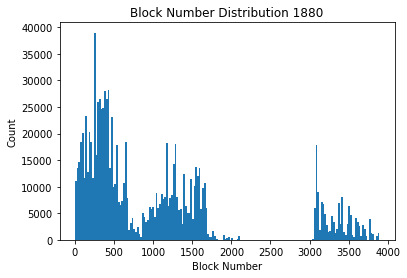

In [15]:
plt.hist(census_1880["block_num"], bins = "auto")
plt.title("Block Number Distribution 1880")
plt.xlabel("Block Number")
plt.ylabel("Count")
plt.show()

/Users/tabithasugumar/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:403: RuntimeWarning: invalid value encountered in greater_equal
  keep = (a >= first_edge)
/Users/tabithasugumar/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:404: RuntimeWarning: invalid value encountered in less_equal
  keep &= (a <= last_edge)
/Users/tabithasugumar/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/tabithasugumar/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


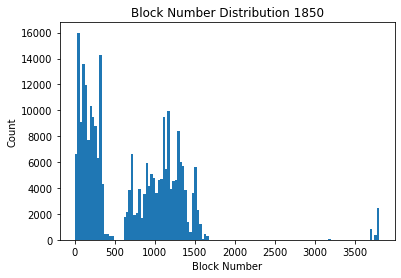

In [16]:
plt.hist(filled_1850["block_num"], bins = "auto")
plt.title("Block Number Distribution 1850")
plt.xlabel("Block Number")
plt.ylabel("Count")
plt.show()

In [18]:
print("Number of unique block numbers in 1880:", census_1880["block_num"].nunique())
print("Number of unique block numbers in 1850:", filled_1850["block_num"].nunique())

Number of unique block numbers in 1880: 2126
Number of unique block numbers in 1850: 1010


So the distributions are pretty similar, although of 1880 has far more numbers. Let's get a sense of wards, by looking at the historically chose sample with overlap

In [19]:
print("Wards in 1880:", census_1880["WARD_NUM"].unique())
print("Wards in 1850:", filled_1850["WARD_NUM"].unique())

Wards in 1880: [ 1.  3.  2.  5.  4.  6. 14. 10. 15. 17. 18.  7.  8. 13. 11.  9. 16. 21.
 20. 22. 19. 12.]
Wards in 1850: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


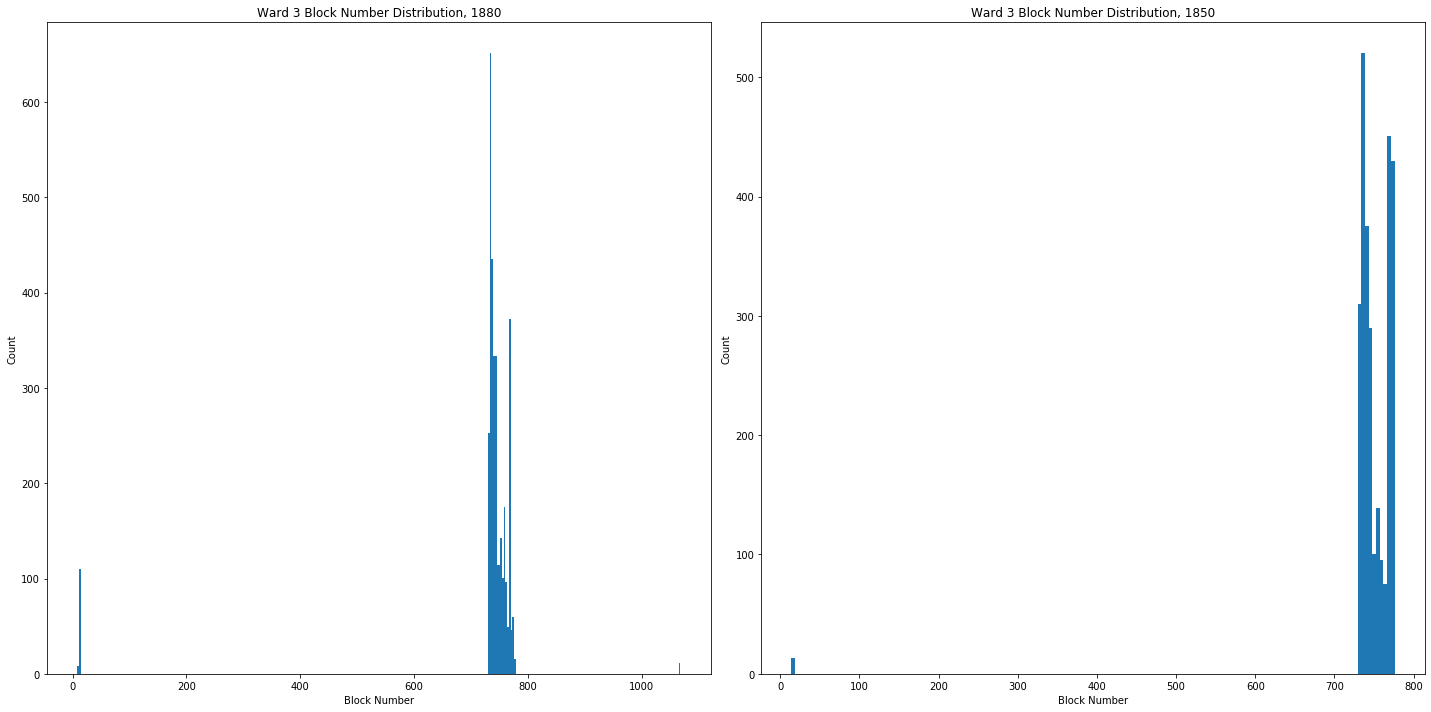

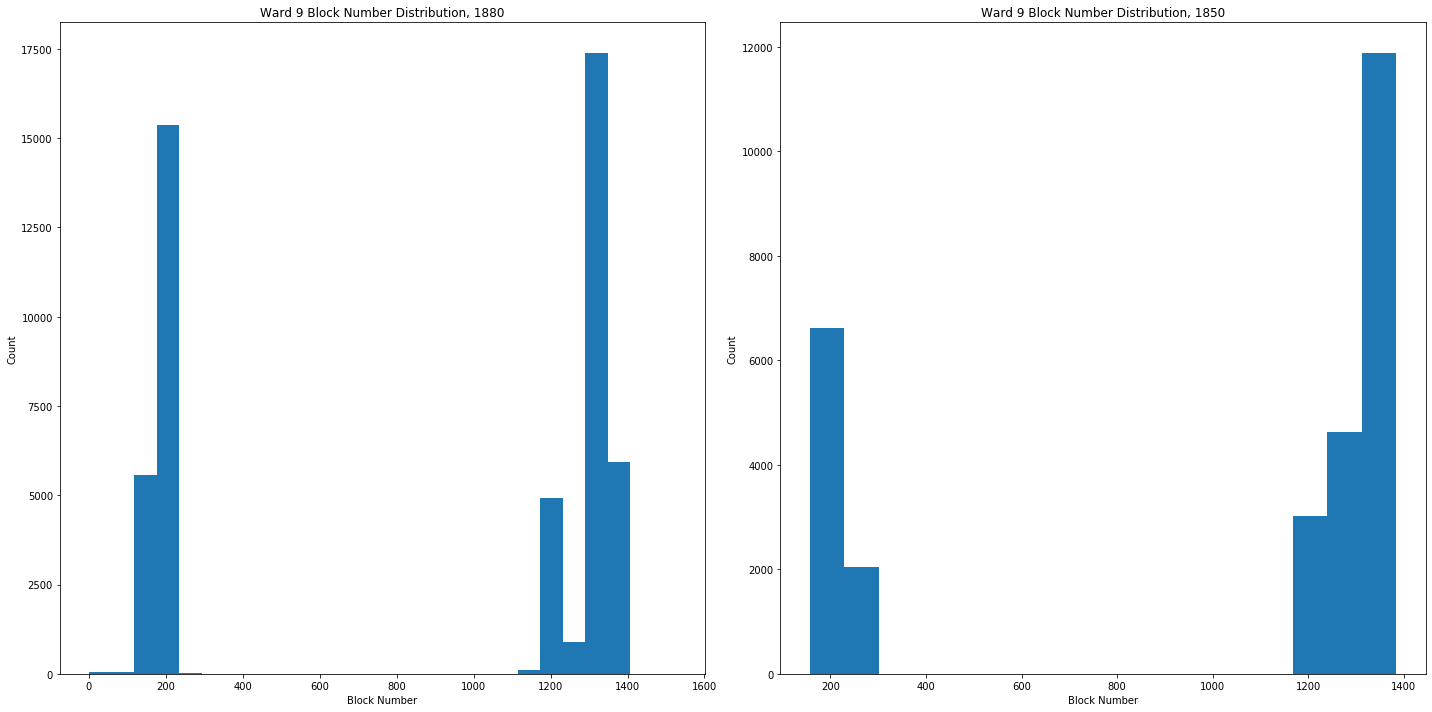

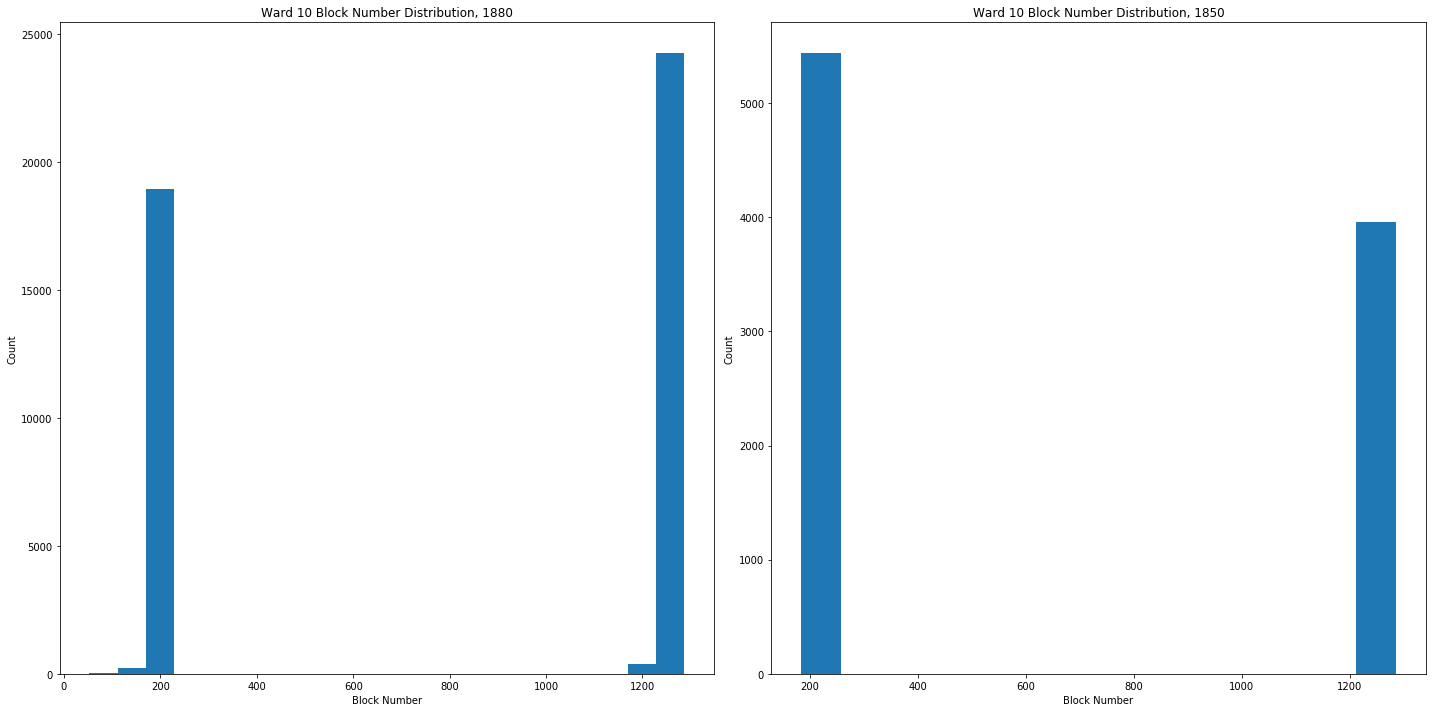

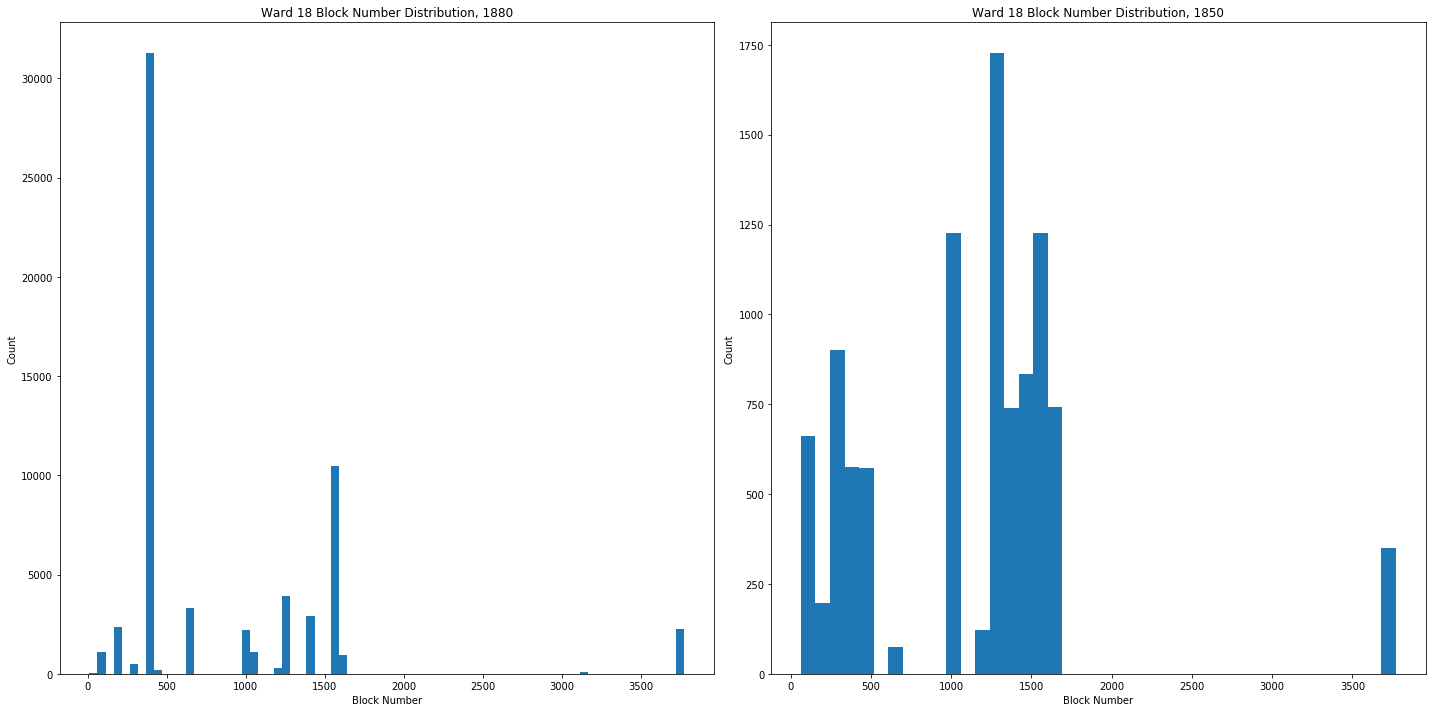

In [20]:
#wards present in both years from previously selected sample
wards = [3, 9, 10, 18]
for ward in wards:
    fig, ax = plt.subplots(1, 2, figsize=(20,10))
    plot_1880 = census_1880[census_1880["WARD_NUM"] == ward]
    plot_1850 = filled_1850[filled_1850["WARD_NUM"] == ward]
    
    ax[0].hist(plot_1880["block_num"], bins = "auto")
    ax[0].set_title("Ward "+str(ward)+" Block Number Distribution, 1880")
    ax[0].set_xlabel("Block Number")
    ax[0].set_ylabel("Count")
    
    ax[1].hist(plot_1850["block_num"], bins = "auto")
    ax[1].set_title("Ward "+str(ward)+" Block Number Distribution, 1850")
    ax[1].set_xlabel("Block Number")
    ax[1].set_ylabel("Count")
    
    plt.tight_layout()
    plt.show()

Again, very similar block number distributions between years, ward specific, this indicates again that using 1880 to train for 1850 will work

### Let's try adding in Block Numbers for a Simple Linear Model and Seeing how well that works

In [11]:
#get dwellings level dataset
dwellings_1850 = filled_1850.groupby(["WARD_NUM", "CENSUS_DWELLING_NUM"], as_index = False).first()
dwellings_1880 = census_1880.drop_duplicates(subset = ["CENSUS_ADDRESS"]).copy()

In [12]:
interpolation.col_for_seq(dwellings_1850, "CD_X", "CD_Y", Address = None, Ward = None)
interpolation.col_for_seq(dwellings_1880, "POINT_X", "POINT_Y", Address = None, Ward = None)
dwellings_1850 = interpolation.get_dist_seq(dwellings_1850, 0.15)[2]
dwellings_1880 = interpolation.get_dist_seq(dwellings_1880, 0.15)[2]
dwellings_1850.groupby("sequence_id").apply(interpolation.sequence_order)
dwellings_1880.groupby("sequence_id").apply(interpolation.sequence_order)
census_1880_model = interpolation.dwellings_to_all(census_1880, dwellings_1880, ["CENSUS_MATCH_ADDR", "sequence_id", "sequence_order"], ["CENSUS_MATCH_ADDR"])
census_1850_model = interpolation.dwellings_to_all(filled_1850, dwellings_1850, ["WARD_NUM", "CENSUS_DWELLING_NUM","sequence_id", "sequence_order"], ["WARD_NUM", "CENSUS_DWELLING_NUM"])
interpolation.create_street_house(census_1880_model, "CENSUS_ADDRESS")
interpolation.create_street_house(census_1850_model, "CD_ADDRESS")

In [52]:
cols = ["street_name", "sequence_id", "sequence_order", "WARD_NUM", "CENSUS_SERIALB", "block_num"]
train_X, train_y, test_1880_X, test_1880_y, test_1850_X, test_1850_y = interpolation.create_train_test_data(census_1880_model, census_1850_model, cols)

In [53]:
#This improves performance on 1850 dataset a little bit, but it's worth experimenting
#with other models (I want to try gradient boosting, and perhaps neural networks, but I
#don't think autoencoders will work well because of the way the sequences are structured)
model_lin_order = Pipeline([('preprocess', TargetEncoder(cols = cols)),
                            ('regressor', LinearRegression())])
model_lin_order.fit(train_X, train_y)
print("Training score:", model_lin_order.score(train_X, train_y))
print("Test 1850 score:", model_lin_order.score(test_1850_X, test_1850_y))
print("Test 1880 score:", model_lin_order.score(test_1880_X, test_1880_y))

Training score: 0.9667183155535946
Test 1850 score: 0.833173769003649
Test 1880 score: 0.8806329645739307


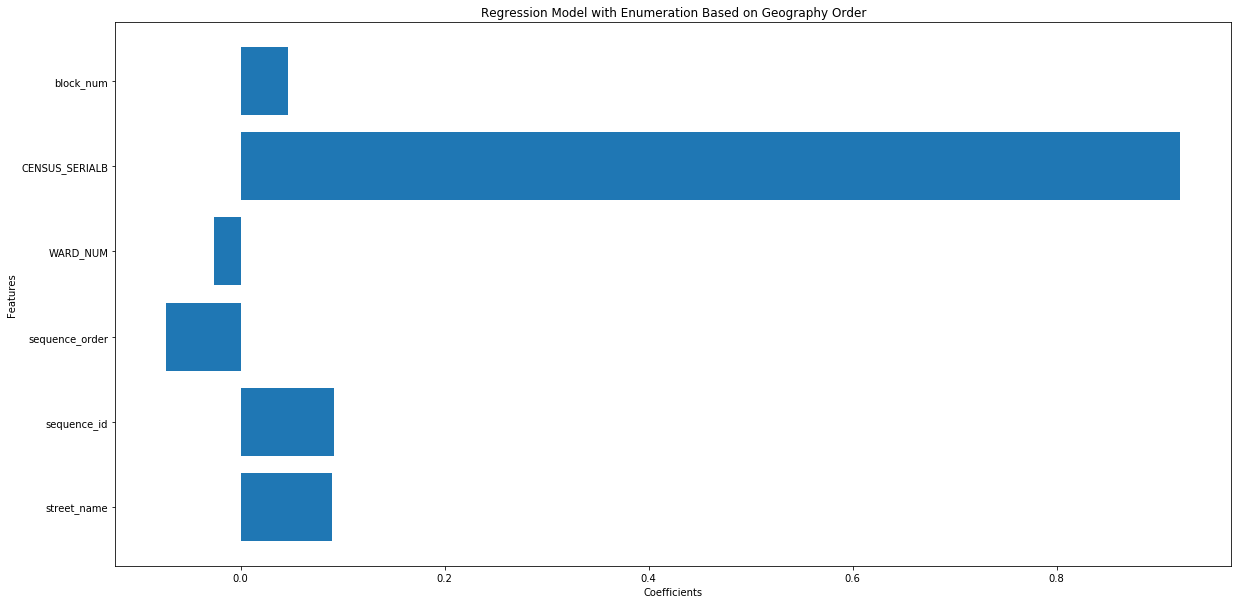

In [54]:
interpolation.graph_coefs(model_lin_order.named_steps['preprocess'].get_feature_names(), model_lin_order.named_steps["regressor"].coef_, "Regression Model with Enumeration Based on Geography Order")

In [55]:
interpolation.create_street_house(dwellings_1880, "CENSUS_ADDRESS")
interpolation.create_street_house(dwellings_1850, "CD_ADDRESS")
cols = ["street_name", "sequence_id", "sequence_order", "WARD_NUM", "block_num"]
train_X, train_y, test_1880_X, test_1880_y, test_1850_X, test_1850_y = interpolation.create_train_test_data(dwellings_1880, dwellings_1850, cols)

/Users/tabithasugumar/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [56]:
model_lin_order = Pipeline([('preprocess', TargetEncoder(cols = cols)),
                            ('regressor', LinearRegression())])
model_lin_order.fit(train_X, train_y)
print("Training score:", model_lin_order.score(train_X, train_y))
print("Test 1850 score:", model_lin_order.score(test_1850_X, test_1850_y))
print("Test 1880 score:", model_lin_order.score(test_1880_X, test_1880_y))

Training score: 0.7550771927771613
Test 1850 score: 0.35819794669180216
Test 1880 score: 0.7288194976280464


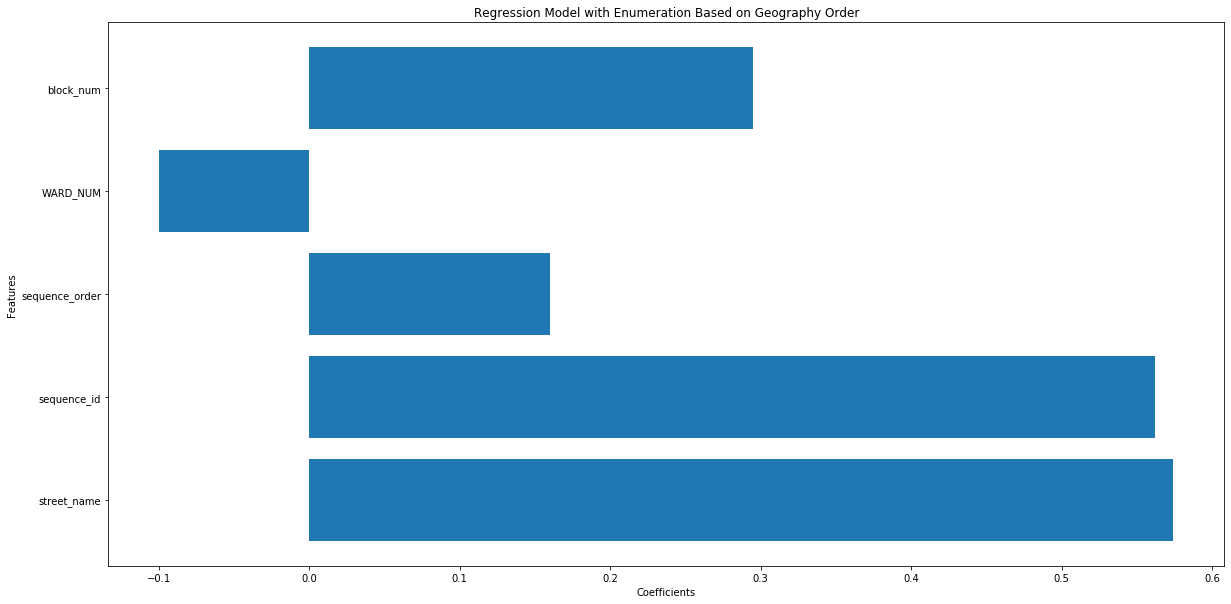

In [57]:
interpolation.graph_coefs(model_lin_order.named_steps['preprocess'].get_feature_names(), model_lin_order.named_steps["regressor"].coef_, "Regression Model with Enumeration Based on Geography Order")

### Consider Feature Options For Predicting Block Numbers in 1850

One of the issues with this approach is that we don't really have many features that actually help us understand the information we have. I think getting ahold of information from the geocoder will really help with the geography of the situation aspect. But what we have right now isn't really enough. Let's start looking at what we know from 1850 about what's inbetween